In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.layers import Dense, Input, Dropout, Activation, Conv2D, MaxPooling2D, Lambda, Flatten, GlobalAveragePooling2D
from keras.layers.merge import concatenate

from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data-ISBI-resized/train/'
validation_dir = 'data-ISBI-resized/validation/'
test_dir = 'data-ISBI-resized/test/'

extracted_features_dir = "extracted_features/"
model_name = "VGG16_MobileNet_Concatenate3_SGD"

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ISBI-resized/train/ 0
data-ISBI-resized/train/malignant 40425
data-ISBI-resized/train/normal 18747
******************************
data-ISBI-resized/test/ 0
data-ISBI-resized/test/malignant 655
data-ISBI-resized/test/normal 312


In [5]:
batch_size = 32
img_height, img_width = 380, 380
input_shape = (img_height, img_width, 3)
epochs = 1000

top_model_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_weights.h5')

In [6]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
#     validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 59170 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [7]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 59170
nb_validation_samples: 18384
nb_test_samples: 967

predict_size_train: 1850
predict_size_validation: 575
predict_size_test: 31

 num_classes: 2


In [8]:
basemodel1=VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x1=basemodel1.get_layer('block5_pool').output
x1=GlobalAveragePooling2D()(x1)

basemodel2=MobileNet(weights=None,input_tensor = basemodel1.input, include_top=False, input_shape=input_shape)
x2 = basemodel2.output
x2 = GlobalAveragePooling2D()(x2)

merge = concatenate([x1, x2])
merge = Dropout(0.6)(merge)
preds = Dense(num_classes, activation='softmax')(merge)
model = Model(inputs=basemodel1.input,outputs=preds)

In [9]:
# bottleneck_final_model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [10]:
c1 = model.layers[74].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[80].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[88].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[96].output
c4 = GlobalAveragePooling2D()(c4)

c5 = model.layers[103].output
c5 = GlobalAveragePooling2D()(c5)


con = concatenate([c1,c2,c3,c4,c5])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [11]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [12]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [13]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [14]:
import tensorflow as tf
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [15]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [16]:
model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

sgd_opt=SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
# adam_opt=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.999, amsgrad=True)
model.compile(optimizer=sgd_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 59170 samples, validate on 18384 samples
Epoch 1/1000
 - 7s - loss: 0.6206 - acc: 0.6814 - val_loss: 0.6105 - val_acc: 0.6806
Epoch 2/1000
 - 6s - loss: 0.6040 - acc: 0.6832 - val_loss: 0.5981 - val_acc: 0.6806
Epoch 3/1000
 - 6s - loss: 0.5900 - acc: 0.6834 - val_loss: 0.5817 - val_acc: 0.6806
Epoch 4/1000
 - 6s - loss: 0.5763 - acc: 0.6881 - val_loss: 0.5687 - val_acc: 0.6812
Epoch 5/1000
 - 6s - loss: 0.5632 - acc: 0.7034 - val_loss: 0.5547 - val_acc: 0.7143
Epoch 6/1000
 - 6s - loss: 0.5512 - acc: 0.7252 - val_loss: 0.5431 - val_acc: 0.7347
Epoch 7/1000
 - 6s - loss: 0.5412 - acc: 0.7420 - val_loss: 0.5344 - val_acc: 0.7658
Epoch 8/1000
 - 6s - loss: 0.5324 - acc: 0.7547 - val_loss: 0.5258 - val_acc: 0.7621
Epoch 9/1000
 - 6s - loss: 0.5270 - acc: 0.7604 - val_loss: 0.5202 - val_acc: 0.7644
Epoch 10/1000
 - 6s - loss: 0.5211 - acc: 0.7656 - val_loss: 0.5149 - val_acc: 0.7684
Epoch 11/1000
 - 6s - loss: 0.5170 - acc: 0.7693 - val_loss: 0.5111 - val_acc: 0.7752
Epoch 12/1000

Epoch 96/1000
 - 6s - loss: 0.4831 - acc: 0.7844 - val_loss: 0.4813 - val_acc: 0.7843
Epoch 97/1000
 - 6s - loss: 0.4824 - acc: 0.7849 - val_loss: 0.4817 - val_acc: 0.7841
Epoch 98/1000
 - 6s - loss: 0.4821 - acc: 0.7847 - val_loss: 0.4801 - val_acc: 0.7863
Epoch 99/1000
 - 6s - loss: 0.4825 - acc: 0.7845 - val_loss: 0.4827 - val_acc: 0.7831
Epoch 100/1000
 - 6s - loss: 0.4819 - acc: 0.7850 - val_loss: 0.4817 - val_acc: 0.7849
Epoch 101/1000
 - 6s - loss: 0.4825 - acc: 0.7838 - val_loss: 0.4801 - val_acc: 0.7865
Epoch 102/1000
 - 6s - loss: 0.4822 - acc: 0.7852 - val_loss: 0.4801 - val_acc: 0.7848
Epoch 103/1000
 - 6s - loss: 0.4815 - acc: 0.7855 - val_loss: 0.4796 - val_acc: 0.7864
Epoch 104/1000
 - 6s - loss: 0.4814 - acc: 0.7849 - val_loss: 0.4850 - val_acc: 0.7839
Epoch 105/1000
 - 6s - loss: 0.4809 - acc: 0.7864 - val_loss: 0.4815 - val_acc: 0.7841
Epoch 106/1000
 - 6s - loss: 0.4811 - acc: 0.7855 - val_loss: 0.4809 - val_acc: 0.7855
Epoch 107/1000
 - 6s - loss: 0.4808 - acc: 0.78

Epoch 191/1000
 - 6s - loss: 0.4677 - acc: 0.7916 - val_loss: 0.4675 - val_acc: 0.7947
Epoch 192/1000
 - 6s - loss: 0.4681 - acc: 0.7918 - val_loss: 0.4676 - val_acc: 0.7936
Epoch 193/1000
 - 6s - loss: 0.4678 - acc: 0.7917 - val_loss: 0.4676 - val_acc: 0.7942
Epoch 194/1000
 - 6s - loss: 0.4679 - acc: 0.7911 - val_loss: 0.4680 - val_acc: 0.7929
Epoch 195/1000
 - 6s - loss: 0.4676 - acc: 0.7923 - val_loss: 0.4671 - val_acc: 0.7943
Epoch 196/1000
 - 6s - loss: 0.4669 - acc: 0.7921 - val_loss: 0.4684 - val_acc: 0.7942
Epoch 197/1000
 - 6s - loss: 0.4672 - acc: 0.7920 - val_loss: 0.4678 - val_acc: 0.7933
Epoch 198/1000
 - 6s - loss: 0.4675 - acc: 0.7908 - val_loss: 0.4685 - val_acc: 0.7943
Epoch 199/1000
 - 6s - loss: 0.4677 - acc: 0.7914 - val_loss: 0.4674 - val_acc: 0.7939
Epoch 200/1000
 - 6s - loss: 0.4666 - acc: 0.7919 - val_loss: 0.4706 - val_acc: 0.7897
Epoch 201/1000
 - 6s - loss: 0.4666 - acc: 0.7920 - val_loss: 0.4678 - val_acc: 0.7944
Epoch 202/1000
 - 6s - loss: 0.4662 - acc: 

 - 6s - loss: 0.4577 - acc: 0.7969 - val_loss: 0.4587 - val_acc: 0.7997
Epoch 286/1000
 - 6s - loss: 0.4570 - acc: 0.7966 - val_loss: 0.4588 - val_acc: 0.8003
Epoch 287/1000
 - 6s - loss: 0.4575 - acc: 0.7959 - val_loss: 0.4588 - val_acc: 0.8006
Epoch 288/1000
 - 6s - loss: 0.4577 - acc: 0.7959 - val_loss: 0.4611 - val_acc: 0.7995
Epoch 289/1000
 - 6s - loss: 0.4567 - acc: 0.7962 - val_loss: 0.4594 - val_acc: 0.8015
Epoch 290/1000
 - 6s - loss: 0.4564 - acc: 0.7976 - val_loss: 0.4581 - val_acc: 0.8000
Epoch 291/1000
 - 6s - loss: 0.4568 - acc: 0.7963 - val_loss: 0.4627 - val_acc: 0.7980
Epoch 292/1000
 - 6s - loss: 0.4565 - acc: 0.7962 - val_loss: 0.4577 - val_acc: 0.8018
Epoch 293/1000
 - 6s - loss: 0.4573 - acc: 0.7961 - val_loss: 0.4577 - val_acc: 0.8014
Epoch 294/1000
 - 6s - loss: 0.4564 - acc: 0.7972 - val_loss: 0.4580 - val_acc: 0.8011
Epoch 295/1000
 - 6s - loss: 0.4562 - acc: 0.7972 - val_loss: 0.4590 - val_acc: 0.8017
Epoch 296/1000
 - 6s - loss: 0.4570 - acc: 0.7961 - val_lo

Epoch 380/1000
 - 6s - loss: 0.4501 - acc: 0.7995 - val_loss: 0.4533 - val_acc: 0.8040
Epoch 381/1000
 - 6s - loss: 0.4510 - acc: 0.8002 - val_loss: 0.4542 - val_acc: 0.8010
Epoch 382/1000
 - 6s - loss: 0.4509 - acc: 0.7995 - val_loss: 0.4681 - val_acc: 0.7982
Epoch 383/1000
 - 6s - loss: 0.4512 - acc: 0.8001 - val_loss: 0.4532 - val_acc: 0.8041
Epoch 384/1000
 - 6s - loss: 0.4518 - acc: 0.7989 - val_loss: 0.4541 - val_acc: 0.8031
Epoch 385/1000
 - 6s - loss: 0.4518 - acc: 0.7989 - val_loss: 0.4540 - val_acc: 0.8044
Epoch 386/1000
 - 6s - loss: 0.4512 - acc: 0.7991 - val_loss: 0.4577 - val_acc: 0.8012
Epoch 387/1000
 - 6s - loss: 0.4496 - acc: 0.7998 - val_loss: 0.4559 - val_acc: 0.8009
Epoch 388/1000
 - 6s - loss: 0.4509 - acc: 0.8006 - val_loss: 0.4580 - val_acc: 0.8008
Epoch 389/1000
 - 6s - loss: 0.4513 - acc: 0.7995 - val_loss: 0.4529 - val_acc: 0.8037
Epoch 390/1000
 - 6s - loss: 0.4498 - acc: 0.7998 - val_loss: 0.4560 - val_acc: 0.8027
Epoch 391/1000
 - 6s - loss: 0.4507 - acc: 

 - 6s - loss: 0.4455 - acc: 0.8025 - val_loss: 0.4512 - val_acc: 0.8061
Epoch 475/1000
 - 6s - loss: 0.4453 - acc: 0.8027 - val_loss: 0.4516 - val_acc: 0.8038
Epoch 476/1000
 - 6s - loss: 0.4458 - acc: 0.8016 - val_loss: 0.4511 - val_acc: 0.8049
Epoch 477/1000
 - 6s - loss: 0.4447 - acc: 0.8030 - val_loss: 0.4521 - val_acc: 0.8046
Epoch 478/1000
 - 6s - loss: 0.4455 - acc: 0.8029 - val_loss: 0.4503 - val_acc: 0.8056
Epoch 479/1000
 - 6s - loss: 0.4456 - acc: 0.8023 - val_loss: 0.4493 - val_acc: 0.8059
Epoch 480/1000
 - 6s - loss: 0.4459 - acc: 0.8023 - val_loss: 0.4489 - val_acc: 0.8058
Epoch 481/1000
 - 6s - loss: 0.4449 - acc: 0.8022 - val_loss: 0.4533 - val_acc: 0.8041
Epoch 482/1000
 - 6s - loss: 0.4458 - acc: 0.8027 - val_loss: 0.4501 - val_acc: 0.8056
Epoch 483/1000
 - 6s - loss: 0.4456 - acc: 0.8026 - val_loss: 0.4508 - val_acc: 0.8056
Epoch 484/1000
 - 6s - loss: 0.4453 - acc: 0.8020 - val_loss: 0.4522 - val_acc: 0.8042
Epoch 485/1000
 - 6s - loss: 0.4456 - acc: 0.8021 - val_lo

Epoch 569/1000
 - 6s - loss: 0.4419 - acc: 0.8037 - val_loss: 0.4484 - val_acc: 0.8067
Epoch 570/1000
 - 6s - loss: 0.4416 - acc: 0.8042 - val_loss: 0.4468 - val_acc: 0.8081
Epoch 571/1000
 - 6s - loss: 0.4426 - acc: 0.8040 - val_loss: 0.4488 - val_acc: 0.8064
Epoch 572/1000
 - 6s - loss: 0.4424 - acc: 0.8043 - val_loss: 0.4477 - val_acc: 0.8074
Epoch 573/1000
 - 6s - loss: 0.4418 - acc: 0.8039 - val_loss: 0.4463 - val_acc: 0.8080
Epoch 574/1000
 - 6s - loss: 0.4415 - acc: 0.8040 - val_loss: 0.4576 - val_acc: 0.8022
Epoch 575/1000
 - 6s - loss: 0.4407 - acc: 0.8042 - val_loss: 0.4461 - val_acc: 0.8079
Epoch 576/1000
 - 6s - loss: 0.4407 - acc: 0.8049 - val_loss: 0.4551 - val_acc: 0.8045
Epoch 577/1000
 - 6s - loss: 0.4408 - acc: 0.8046 - val_loss: 0.4475 - val_acc: 0.8076
Epoch 578/1000
 - 6s - loss: 0.4402 - acc: 0.8056 - val_loss: 0.4491 - val_acc: 0.8085
Epoch 579/1000
 - 6s - loss: 0.4405 - acc: 0.8049 - val_loss: 0.4469 - val_acc: 0.8056
Epoch 580/1000
 - 6s - loss: 0.4408 - acc: 

 - 6s - loss: 0.4381 - acc: 0.8058 - val_loss: 0.4440 - val_acc: 0.8124
Epoch 664/1000
 - 6s - loss: 0.4387 - acc: 0.8068 - val_loss: 0.4475 - val_acc: 0.8054
Epoch 665/1000
 - 6s - loss: 0.4378 - acc: 0.8081 - val_loss: 0.4443 - val_acc: 0.8109
Epoch 666/1000
 - 6s - loss: 0.4384 - acc: 0.8054 - val_loss: 0.4467 - val_acc: 0.8085
Epoch 667/1000
 - 6s - loss: 0.4388 - acc: 0.8054 - val_loss: 0.4425 - val_acc: 0.8101
Epoch 668/1000
 - 6s - loss: 0.4378 - acc: 0.8064 - val_loss: 0.4419 - val_acc: 0.8109
Epoch 669/1000
 - 6s - loss: 0.4386 - acc: 0.8065 - val_loss: 0.4447 - val_acc: 0.8083
Epoch 670/1000
 - 6s - loss: 0.4383 - acc: 0.8056 - val_loss: 0.4435 - val_acc: 0.8110
Epoch 671/1000
 - 6s - loss: 0.4377 - acc: 0.8070 - val_loss: 0.4530 - val_acc: 0.8061
Epoch 672/1000
 - 6s - loss: 0.4379 - acc: 0.8059 - val_loss: 0.4434 - val_acc: 0.8111
Epoch 673/1000
 - 6s - loss: 0.4378 - acc: 0.8089 - val_loss: 0.4437 - val_acc: 0.8092
Epoch 674/1000
 - 6s - loss: 0.4383 - acc: 0.8064 - val_lo

Epoch 758/1000
 - 6s - loss: 0.4353 - acc: 0.8071 - val_loss: 0.4424 - val_acc: 0.8136
Epoch 759/1000
 - 6s - loss: 0.4345 - acc: 0.8087 - val_loss: 0.4532 - val_acc: 0.8022
Epoch 760/1000
 - 6s - loss: 0.4346 - acc: 0.8086 - val_loss: 0.4409 - val_acc: 0.8093
Epoch 761/1000
 - 6s - loss: 0.4355 - acc: 0.8082 - val_loss: 0.4459 - val_acc: 0.8097
Epoch 762/1000
 - 6s - loss: 0.4352 - acc: 0.8070 - val_loss: 0.4410 - val_acc: 0.8126
Epoch 763/1000
 - 6s - loss: 0.4347 - acc: 0.8085 - val_loss: 0.4431 - val_acc: 0.8090
Epoch 764/1000
 - 6s - loss: 0.4347 - acc: 0.8077 - val_loss: 0.4399 - val_acc: 0.8117
Epoch 765/1000
 - 6s - loss: 0.4343 - acc: 0.8082 - val_loss: 0.4433 - val_acc: 0.8080
Epoch 766/1000
 - 6s - loss: 0.4363 - acc: 0.8074 - val_loss: 0.4497 - val_acc: 0.8075
Epoch 767/1000
 - 6s - loss: 0.4344 - acc: 0.8080 - val_loss: 0.4401 - val_acc: 0.8118
Epoch 768/1000
 - 6s - loss: 0.4341 - acc: 0.8063 - val_loss: 0.4452 - val_acc: 0.8048
Epoch 769/1000
 - 6s - loss: 0.4344 - acc: 

 - 6s - loss: 0.4331 - acc: 0.8086 - val_loss: 0.4393 - val_acc: 0.8147
Epoch 853/1000
 - 6s - loss: 0.4339 - acc: 0.8077 - val_loss: 0.4505 - val_acc: 0.8068
Epoch 854/1000
 - 6s - loss: 0.4340 - acc: 0.8071 - val_loss: 0.4398 - val_acc: 0.8143
Epoch 855/1000
 - 6s - loss: 0.4329 - acc: 0.8087 - val_loss: 0.4521 - val_acc: 0.8027
Epoch 856/1000
 - 6s - loss: 0.4332 - acc: 0.8085 - val_loss: 0.4379 - val_acc: 0.8138
Epoch 857/1000
 - 6s - loss: 0.4330 - acc: 0.8084 - val_loss: 0.4403 - val_acc: 0.8153
Epoch 858/1000
 - 6s - loss: 0.4334 - acc: 0.8087 - val_loss: 0.4407 - val_acc: 0.8121
Epoch 859/1000
 - 6s - loss: 0.4332 - acc: 0.8090 - val_loss: 0.4410 - val_acc: 0.8101
Epoch 860/1000
 - 6s - loss: 0.4317 - acc: 0.8093 - val_loss: 0.4393 - val_acc: 0.8149
Epoch 861/1000
 - 6s - loss: 0.4337 - acc: 0.8085 - val_loss: 0.4388 - val_acc: 0.8134
Epoch 862/1000
 - 6s - loss: 0.4337 - acc: 0.8089 - val_loss: 0.4393 - val_acc: 0.8131
Epoch 863/1000
 - 6s - loss: 0.4329 - acc: 0.8087 - val_lo

Epoch 947/1000
 - 6s - loss: 0.4314 - acc: 0.8107 - val_loss: 0.4367 - val_acc: 0.8152
Epoch 948/1000
 - 6s - loss: 0.4300 - acc: 0.8104 - val_loss: 0.4408 - val_acc: 0.8110
Epoch 949/1000
 - 6s - loss: 0.4321 - acc: 0.8096 - val_loss: 0.4367 - val_acc: 0.8157
Epoch 950/1000
 - 6s - loss: 0.4303 - acc: 0.8115 - val_loss: 0.4515 - val_acc: 0.8021
Epoch 951/1000
 - 6s - loss: 0.4308 - acc: 0.8124 - val_loss: 0.4435 - val_acc: 0.8121
Epoch 952/1000
 - 6s - loss: 0.4306 - acc: 0.8098 - val_loss: 0.4374 - val_acc: 0.8108
Epoch 953/1000
 - 6s - loss: 0.4289 - acc: 0.8115 - val_loss: 0.4476 - val_acc: 0.8079
Epoch 954/1000
 - 6s - loss: 0.4301 - acc: 0.8107 - val_loss: 0.4380 - val_acc: 0.8164
Epoch 955/1000
 - 6s - loss: 0.4306 - acc: 0.8099 - val_loss: 0.4376 - val_acc: 0.8123
Epoch 956/1000
 - 6s - loss: 0.4300 - acc: 0.8111 - val_loss: 0.4388 - val_acc: 0.8140
Epoch 957/1000
 - 6s - loss: 0.4309 - acc: 0.8091 - val_loss: 0.4374 - val_acc: 0.8170
Epoch 958/1000
 - 6s - loss: 0.4292 - acc: 

In [17]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

18384/18384 [==============================] - 1s 41us/step
Validation Accuracy: 81.3098%
Validation Loss: 0.441483124351377


In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8976215098241985


Confusion Matrix
[[654   1]
 [ 98 214]]


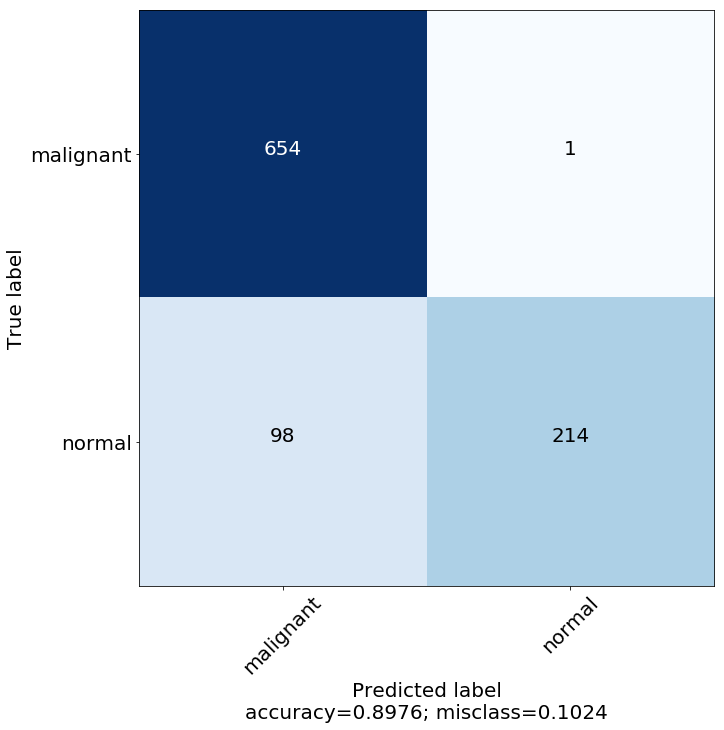

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[654   1]
 [ 98 214]]
              precision    recall  f1-score   support

   malignant       0.87      1.00      0.93       655
      normal       1.00      0.69      0.81       312

   micro avg       0.90      0.90      0.90       967
   macro avg       0.93      0.84      0.87       967
weighted avg       0.91      0.90      0.89       967



In [21]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  86.96808510638297
Specificity :  99.53488372093024


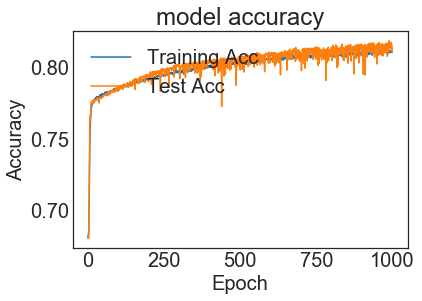

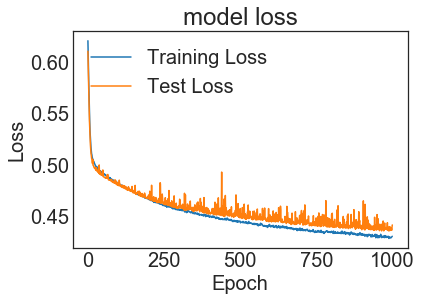

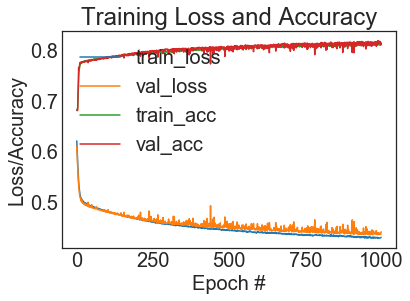

In [22]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [23]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

967/967 [==============================] - 0s 31us/step
Precision =  0.9102272954044578
Recall =  0.8976215098241985
f1_score =  0.8917286186812373


In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.842185359170092


In [25]:
sample_count = test_generator.samples
print('Sample count: {}'.format(sample_count))

fnames = test_generator.filenames
ground_truth = test_generator.classes
label2index = test_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v, k) for k, v in label2index.items())
predictions = model.predict_classes(test_data)
prob = model.predict(test_data)
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), sample_count))

Sample count: 967
No of errors = 99/967
